##**Notebook PC#08**
## Simple Recurrent Neural Network, Linear Predictor, MLP and LSTM for multi-step time series prediction.<BR>

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Ariel Góes de Castro <br>
**Aluno(a):** Francisco Germano Vogt

In [1]:
# Loading all the relevant libraries
from pandas import read_csv
from pandas import DataFrame
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

## **A base [unemployment rate] foi baixada no [link](https://fred.stlouisfed.org/series/UNRATE).**

In [ ]:
# Structuring the dataset from a single time series, scaling and spliting into training / testing
def get_train_test(dataset, split_percent, time_steps, horizon):
    df = read_csv(dataset, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    # There is a kind of data leakage in the next command
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    df = DataFrame()
    for i in range(0,time_steps):
      df['t-' + str(time_steps-i-1)] = [data[j] for j in range(i, (len(data)-horizon-time_steps+i+1))]
    for i in range(1,horizon+1):
      df['t+' + str(i)] = [data[j] for j in range(time_steps+i-1, (len(data)-horizon+i))]
    print(df)
    df1 = df.copy()
    for i in range(1,horizon+1):
      df1 = df1.drop(['t+' + str(i)], axis = 1)
    dataX = np.array(df1) #separacao de dados de time_steps
    df2 = df['t+1']
    for i in range(2,horizon+1):
      df2 = pd.concat([df2, df['t+' + str(i)]], axis=1)
    datay = np.array(df2) #separacao de dados de horizon
    # Point for splitting data into train and test
    split = int(n*split_percent)
    X = dataX[range(split),:]
    y = datay[range(split)]
    Xt = dataX[split:,:]
    yt = datay[split:]
    return X, y, Xt, yt

time_steps = 11
horizon = 3
# Here you will decide which dataset to consider.
# X, y, Xt, yt = get_train_test('unemployment_rate.csv', 0.8, time_steps, horizon)
X, y, Xt, yt = get_train_test('monthly_sunspot.csv', 0.8, time_steps, horizon)

In [ ]:
print(X.shape)
print(y.shape)

## **Implementing the simple recurrent neural network**

In [ ]:
# Execute this cell or the cell associated with one of the other predictors. They are mutually exclusive.
def create_RNN(hidden_units, dense_units, input_shape, activation):
        model = Sequential()
        model.add(SimpleRNN(hidden_units, activation=activation[0], input_shape=input_shape))
        model.add(Dense(units=dense_units, activation=activation[1]))
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model

def RNN_predictor (X, y, time_steps):
    model = create_RNN(hidden_units=30, dense_units=horizon, input_shape=(time_steps,1), activation=['tanh', 'tanh'])
    train_predict = model.fit(X, y, epochs=20, batch_size=1, verbose=2)
    return model

RNN_model = RNN_predictor(X, y, time_steps)

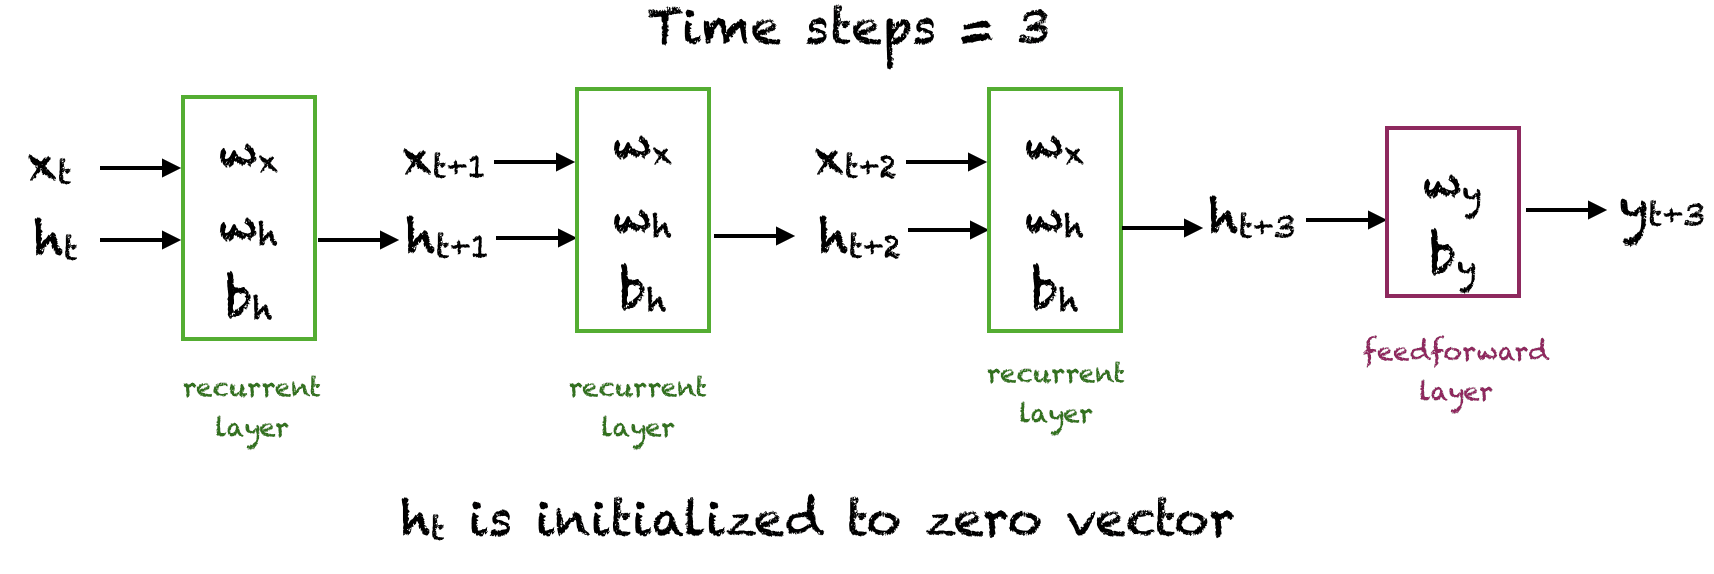

In [5]:
# [Do not run this cell] or [Upload the PNG file and then run].
# Configuration of the simple RNN
from IPython.display import Image
Image("RNN_info_flow.png", width = 600, height = 300)

In [ ]:
wx = RNN_model.get_weights()[0]
wh = RNN_model.get_weights()[1]
bh = RNN_model.get_weights()[2]
wy = RNN_model.get_weights()[3]
by = RNN_model.get_weights()[4]
print(wx.shape)
print(wh.shape)
print(bh.shape)
print(wy.shape)
print(by.shape)

## **Implementing a linear predictor**

In [ ]:
# Execute this cell or the cell associated with one of the other predictors. They are mutually exclusive.
def linear_predictor(X,y):
    model = LinearRegression()
    train_predict = model.fit(X, y)
    print(model.coef_)
    print(model.intercept_)

    return model

linear_model = linear_predictor(X,y)

## **Implementing the multilayer perceptron neural network (MLP)**

In [ ]:
# Execute this cell or the cell associated with one of the other predictors. They are mutually exclusive.
def MLP_predictor():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(80, activation=tf.nn.tanh),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(horizon, activation='linear')
  ])
  model.compile(optimizer='adam', loss='mean_squared_error')
  train_predict = model.fit(X, y, epochs=100)
  model.summary()

  return model

MLP_model = MLP_predictor()

## **Implementing the long short-term memory network (LSTM)**

In [ ]:
def LSTM_predictor(X, y, time_steps):
    X1 = X.reshape(X.shape[0],time_steps,1)
    model=Sequential()
    model.add(LSTM(25,input_shape=(time_steps,1)))
    model.add(Dense(horizon,activation='linear'))
    model.compile(loss='mean_squared_error',optimizer='adam')

    train_predict = model.fit(X1,y,epochs=200,verbose=2)

    return model

LSTM_model = LSTM_predictor(X, y, time_steps)
print(LSTM_model.summary())

In [10]:
def print_error(trainY, testY, train_predict, test_predict,i):
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('t+%d RMSE train: %.3f RMSE' % (i+1, train_rmse))
    print('t+%d RMSE test: %.3f RMSE' % (i+1, test_rmse))
    return [train_rmse, test_rmse]


def RMSE(train_predict, test_predict):
  rmse = []
  for i in range(horizon):
    if(horizon == 1):
      y1_pred = train_predict
      y1_pred_t = test_predict
      y1 = y
      y1_t = yt
    elif(horizon > 1):
      y1_pred = train_predict[:,i]
      y1_pred_t = test_predict[:,i]
      y1 = y[:,i]
      y1_t = yt[:,i]

    erro = print_error(y1, y1_t, y1_pred, y1_pred_t,i)
    rmse.append(erro)

  # Create a DataFrame from the rmse values for each horizon
  df = pd.DataFrame(rmse)
  df.columns = ['train', 'test']
  return df


In [11]:
# Plot the predictions together with the actual values
def plot_result(trainY, testY, train_predict, test_predict,i):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(30, 6), dpi=300)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Time steps')
    plt.ylabel('Actual and Predicted Values')
    plt.title('t+%d Predition (The Red Line Separates The Training And Test Examples)' % (i+1))
    plt.grid(True)

def plot_predict(train_predict, test_predict, y, yt):
  for i in range(horizon):
    if(horizon == 1):
      y1_pred = train_predict
      y1_pred_t = test_predict
      y1 = y
      y1_t = yt
    elif(horizon > 1):
      y1_pred = train_predict[:,i]
      y1_pred_t = test_predict[:,i]
      y1 = y[:,i]
      y1_t = yt[:,i]
    plot_result(y1, y1_t, y1_pred, y1_pred_t,i)


In [ ]:
print ('***** RNN MODEL *****')
train_predict = RNN_model.predict(X)
test_predict = RNN_model.predict(Xt)
df1 = RMSE(train_predict, test_predict)
plot_predict(train_predict, test_predict, y, yt)

In [ ]:
print ('***** LINEAR MODEL *****')
train_predict = linear_model.predict(X)
test_predict = linear_model.predict(Xt)
df2 = RMSE(train_predict, test_predict)
plot_predict(train_predict, test_predict, y, yt)

In [ ]:
print ('***** MLP MODEL *****')
train_predict = MLP_model.predict(X)
test_predict = MLP_model.predict(Xt)
df3 = RMSE(train_predict, test_predict)
plot_predict(train_predict, test_predict, y, yt)

In [ ]:
print ('***** LSTM MODEL *****')
train_predict = LSTM_model.predict(X)
test_predict = LSTM_model.predict(Xt)
df4 = RMSE(train_predict, test_predict)
plot_predict(train_predict, test_predict, y, yt)

In [16]:
# Plot the prediction error
def plot_result2(trainY, testY, train_predict, test_predict,i):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(30, 6), dpi=300)
    plt.plot(range(rows), actual - predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.xlabel('Time steps')
    plt.ylabel('Actual minus Predicted Values')
    plt.title('t+%d Predition Error (The Red Line Separates The Training And Test Examples)' % (i+1))
    plt.ylim(-0.5, +1.0) # Please, set the interval appropriately, considering all the graphs.
    plt.grid(True)

def plot_error_predict(train_predict, test_predict, y, yt):
    for i in range(horizon):
      if(horizon == 1):
        y1_pred = train_predict
        y1_pred_t = test_predict
        y1 = y
        y1_t = yt
      elif(horizon > 1):
        y1_pred = train_predict[:,i]
        y1_pred_t = test_predict[:,i]
        y1 = y[:,i]
        y1_t = yt[:,i]
      plot_result2(y1, y1_t, y1_pred, y1_pred_t,i)

In [ ]:
print ('***** RNN MODEL *****')
train_predict = RNN_model.predict(X)
test_predict = RNN_model.predict(Xt)
plot_error_predict(train_predict, test_predict, y, yt)


In [ ]:
print ('***** LINEAR MODEL *****')
train_predict = linear_model.predict(X)
test_predict = linear_model.predict(Xt)
plot_error_predict(train_predict, test_predict, y, yt)

In [ ]:
print ('***** MLP MODEL *****')
train_predict = MLP_model.predict(X)
test_predict = MLP_model.predict(Xt)
plot_error_predict(train_predict, test_predict, y, yt)

In [ ]:
print ('***** LSTM MODEL *****')
train_predict = LSTM_model.predict(X)
test_predict = LSTM_model.predict(Xt)
plot_error_predict(train_predict, test_predict, y, yt)

## **Exhibit a dataframe with the final results for each predictor**

In [ ]:
DF_results = pd.concat([df1, df2, df3, df4], axis=1, keys=['RNN', 'LINEAR', 'MLP', 'LSTM'])
DF_results.index = ['t+1', 't+2', 't+3']
DF_results

## **Use the SimpleRNN model to make a search for the best [time_steps].**

In [ ]:
time_steps = [1, 2, 7, 11, 50]
horizon = 3
DF1 = pd.DataFrame()

for timesteps in time_steps:
    X, y, Xt, yt = get_train_test('unemployment_rate.csv', 0.8, timesteps, horizon)
    RNN_model = RNN_predictor(X, y, timesteps)
    train_predict = RNN_model.predict(X)
    test_predict = RNN_model.predict(Xt)
    rmse  = RMSE(train_predict, test_predict)
    rmse.columns = pd.MultiIndex.from_product([[timesteps], rmse.columns])
    DF1 = pd.concat([DF1, rmse], axis=1)

In [ ]:
DF1.index = ['t+1', 't+2', 't+3']
DF1

## **Use the LSTM model to make a search for the best [time_steps].**

In [ ]:
time_steps = [1, 2, 7, 11, 50]
horizon = 3
DF2 = pd.DataFrame()

for timesteps in time_steps:
    X, y, Xt, yt = get_train_test('unemployment_rate.csv', 0.8, timesteps, horizon)
    LSTM_model = LSTM_predictor(X, y, timesteps)
    train_predict = LSTM_model.predict(X)
    test_predict = LSTM_model.predict(Xt)
    rmse  = RMSE(train_predict, test_predict)
    rmse.columns = pd.MultiIndex.from_product([[timesteps], rmse.columns])
    DF2 = pd.concat([DF2, rmse], axis=1)

In [ ]:
DF2.index = ['t+1', 't+2', 't+3']
DF2

(a)	Explique o papel dos parâmetros de projeto [time_steps] e [horizon].

**Resposta:**<BR>

(b)	Qual a diferença no uso do parâmetro [time_steps] no caso dos preditores não-recorrentes e no caso do bloco LSTM?

**Resposta:**<BR>

(c)	Qual modelo de predição levou a um melhor desempenho junto aos dados de teste em cada caso?

**Resposta:**<BR>

(d)	Ao se variar o [horizon], apresente uma hipótese para a perda de desempenho conforme [horizon] cresce de 1 até 3, comportamento produzido por todos os modelos de predição, nos dois casos de estudo.

**Resposta:**<BR>

(e)	Ao se variar o [time_steps] especificamente para os modelos SimpleRNN e LSTM, procure explicar o comportamento observado em cada caso de estudo.

**Resposta:**<BR>